In [ ]:
%pip install pandas sentence-transformers hdbscan numpy matplotlib umap-learn


import json
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from collections import defaultdict
import numpy as np
import pandas as pd
import random

# Load JSON data
with open('extracted_events.json', 'r') as f:
    data = json.load(f)

# Extract text data (e.g., 'Phrase Summary')
texts = [
    entry['Phrase Summary']
    for sublist in data
    for entry in sublist
]


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
# Initialize Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each text entry
embeddings = model.encode(texts, show_progress_bar=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/296 [00:00<?, ?it/s]

In [4]:
# Dimensionality Reduction with UMAP

# Reduce embeddings to 2D using UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.05, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
# HDBSCAN Parameter Tuning

# Function to test multiple HDBSCAN parameter configurations
def tune_hdbscan(embeddings, min_cluster_sizes, min_samples_values):
    results = []
    for min_cluster_size in min_cluster_sizes:
        for min_samples in min_samples_values:
            clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
            labels = clusterer.fit_predict(embeddings)

            # Record the results
            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_points = list(labels).count(-1)
            results.append({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'num_clusters': num_clusters,
                'noise_points': noise_points
            })
            print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples} -> Clusters: {num_clusters}, Noise Points: {noise_points}")

    return pd.DataFrame(results)

# Define the range of parameters to test
min_cluster_sizes = [5, 10, 15]
min_samples_values = [1, 2, 5]

# Run parameter tuning
hdbscan_results = tune_hdbscan(embeddings, min_cluster_sizes, min_samples_values)
print(hdbscan_results)


min_cluster_size=5, min_samples=1 -> Clusters: 364, Noise Points: 5940
min_cluster_size=5, min_samples=2 -> Clusters: 258, Noise Points: 6816
min_cluster_size=5, min_samples=5 -> Clusters: 91, Noise Points: 8013
min_cluster_size=10, min_samples=1 -> Clusters: 105, Noise Points: 7117
min_cluster_size=10, min_samples=2 -> Clusters: 78, Noise Points: 7648
min_cluster_size=10, min_samples=5 -> Clusters: 48, Noise Points: 8259
min_cluster_size=15, min_samples=1 -> Clusters: 53, Noise Points: 7474
min_cluster_size=15, min_samples=2 -> Clusters: 42, Noise Points: 7847
min_cluster_size=15, min_samples=5 -> Clusters: 2, Noise Points: 3268
   min_cluster_size  min_samples  num_clusters  noise_points
0                 5            1           364          5940
1                 5            2           258          6816
2                 5            5            91          8013
3                10            1           105          7117
4                10            2            78          7

In [9]:
# Choosing Optimal HDBSCAN Parameters

# Best HDBSCAN parameters based on tuning results
best_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
cluster_labels = best_clusterer.fit_predict(embeddings)

# Filter out noise points (label = -1) for visualization and analysis
valid_points = cluster_labels != -1
filtered_embeddings = embeddings[valid_points]
filtered_labels = cluster_labels[valid_points]
filtered_texts = [texts[i] for i in range(len(texts)) if valid_points[i]]


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


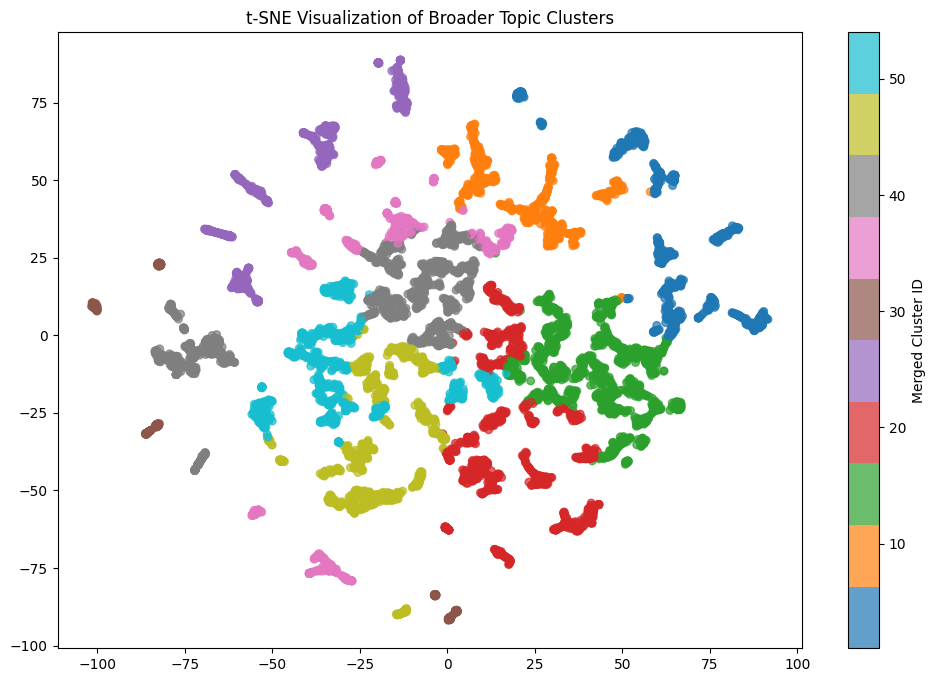

{1: 104, 2: 185, 3: 118, 4: 271, 5: 151, 6: 74, 7: 177, 8: 190, 9: 237, 10: 88, 11: 126, 12: 249, 13: 333, 14: 189, 15: 244, 16: 343, 17: 312, 18: 73, 19: 325, 20: 169, 21: 144, 22: 209, 23: 203, 24: 194, 25: 123, 26: 148, 27: 87, 28: 47, 29: 39, 30: 26, 31: 59, 32: 66, 33: 47, 34: 161, 35: 183, 36: 133, 37: 85, 38: 126, 39: 287, 40: 299, 41: 294, 42: 400, 43: 74, 44: 57, 45: 236, 46: 299, 47: 300, 48: 143, 49: 178, 50: 200, 51: 208, 52: 125, 53: 125, 54: 190}


In [13]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster, linkage
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import hdbscan
import random

# 1. Preprocess embeddings with PCA for smoothing
pca = PCA(n_components=50, random_state=42)
pca_embeddings = pca.fit_transform(embeddings)

# 2. Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.05, random_state=42)
umap_embeddings = umap_model.fit_transform(pca_embeddings)

# 3. Cluster with HDBSCAN with higher min_cluster_size for topic-level clusters
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=10, metric='euclidean')
cluster_labels = clusterer.fit_predict(umap_embeddings)

# 4. Optional: Use Agglomerative Clustering to merge smaller HDBSCAN clusters into broader topics
# Find linkages between clusters to merge similar clusters together
linkage_matrix = linkage(umap_embeddings, method='ward')
# Merge into broader clusters (tune the threshold parameter to control granularity)
merged_labels = fcluster(linkage_matrix, t=10, criterion='distance')

# Plot merged clusters (t-SNE plot, only color by merged labels for broader topics)
tsne_embeddings = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(umap_embeddings)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1],
                      c=merged_labels, cmap='tab10', alpha=0.7, s=30)
plt.title('t-SNE Visualization of Broader Topic Clusters')
plt.colorbar(scatter, label='Merged Cluster ID')
plt.show()

# Display counts of points per merged topic cluster to assess topic coherence
unique, counts = np.unique(merged_labels, return_counts=True)
print(dict(zip(unique, counts)))


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

# Function to extract keywords and examples for each cluster
def get_cluster_descriptions(texts, labels):
    cluster_descriptions = {}
    vectorizer = TfidfVectorizer(max_features=5, stop_words='english')

    for cluster_id in set(labels):
        if cluster_id == -1:  # Skip noise points if any
            continue

        # Get texts for the current cluster
        cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == cluster_id]

        # Generate keywords using TF-IDF
        tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        keywords = vectorizer.get_feature_names_out()

        # Select a few representative examples
        examples = cluster_texts[:3]  # Select first 3 texts as examples

        # Store the cluster description
        cluster_descriptions[cluster_id] = {
            "keywords": keywords,
            "examples": examples
        }

    return cluster_descriptions

# Generate descriptions for each cluster
cluster_descriptions = get_cluster_descriptions(filtered_texts, merged_labels)

# Print the key map for reference
for cluster_id, details in cluster_descriptions.items():
    print(f"Cluster {cluster_id}")
    print("Keywords:", ", ".join(details["keywords"]))
    print("Examples:")
    for example in details["examples"]:
        print(f"- {example}")
    print("\n")


Cluster 1
Keywords: announced, awesome, book, project, turtles
Examples:
- Adaptation of 'Looking for Alaska' released
- Meeting John on Tuesday
- Book tour anticipation


Cluster 2
Keywords: awesome, day, esther, project, sponsor
Examples:
- Celebrated Esther day
- Daniel won a seat in the Illinois State House of Representatives
- Expressing love and admiration for Hank


Cluster 3
Keywords: alaska, course, crisis, launched, looking
Examples:
- Published first novel Looking for Alaska
- Meeting John on Tuesday
- Reflecting on writing 'Looking for Alaska' during a mental health crisis


Cluster 4
Keywords: awesome, cancer, gratitude, movie, project
Examples:
- Preparing for Project for Awesome
- Launched Crash Course
- Questioning the inefficiency of traditional healthcare system


Cluster 5
Keywords: event, law, paper, release, way
Examples:
- Annual event Pizzamas
- Discovery of effective drugs against TB
- Promotion of Crash Course Universe podcast and Crash Course Coin


Cluster 6


In [ ]:
# Summarize and Review Clusters

# Generate summaries for manual review
cluster_summaries = {}
for cluster_id in set(filtered_labels):
    if cluster_id == -1:
        continue
    examples = [filtered_texts[i] for i in range(len(filtered_texts)) if filtered_labels[i] == cluster_id][:3]
    keywords_list = keywords[cluster_id]

    # Generate a short summary using keywords and examples
    summary = f"**Cluster {cluster_id} - Theme**: {', '.join(keywords_list)}\n"
    summary += "This section includes events and discussions focused on topics like "
    summary += ", ".join(keywords_list) + ".\n"
    summary += "Example events include:\n"
    for example in examples:
        summary += f"- {example}\n"

    cluster_summaries[cluster_id] = summary
    print(summary)  # Review summaries manually


In [ ]:
# Evaluate Clustering Performance

# Calculate Silhouette Score for cluster quality evaluation
score = silhouette_score(umap_embeddings, cluster_labels)
print(f'Silhouette Score: {score:.2f}')
